In [1]:
# install libraries (quietly)
!pip install pennylane -q
!pip install kaggle -q

In [2]:
# Importing libraries
import json, os, time, copy, torch, pandas as pd, torchvision.transforms as transforms, pennylane as qml, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from random import sample
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader, random_split
from pennylane import numpy as np
from pennylane.templates import RandomLayers
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Set the seed
torch.manual_seed(42)

In [ ]:
# Data donwload and unzip
!kaggle datasets download -d "danielbacioiu/tig-aluminium-5083"
!unzip tig-aluminium-5083.zip

Streaming output truncated to the last 5000 lines.
  inflating: al5083/train/170906-151353-Al 2mm/frame_01056.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01057.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01058.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01059.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01060.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01061.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01062.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01063.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01064.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01065.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01066.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01067.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01068.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01069.png  
  inflating: al5083/train/170906-151353

In [3]:
# Open the training file
#f = open('/content/al5083/train/train.json') # Colab version
f = open('al5083/train/train.json') # Local version
data = json.load(f)

# Create a dictionary to store the data
data_dict = {0:[], 1:[], 2:[],
             3:[], 4: [], 5:[]}
for id, (key, value) in enumerate(data.items()):
      data_dict[value].append(key)

data_dict.pop(4)
data_dict.pop(5)
# Close the file
f.close()

In [5]:
def sample_portion_each(data_dict, num_samples = 200):
    # Sample a portion of each class
    sampled_dict = {}
    for key, value in data_dict.items():
        if len(value) >= num_samples:
            sampled_dict[key] = sample(value, num_samples)
        else:
            sampled_dict[key] = value
    return sampled_dict

# Sampled dictionary
sampled_dict = sample_portion_each(data_dict, 500)

# Create a dataframe for our dataset
df = pd.DataFrame([(k, v) for k, values in sampled_dict.items() for v in values], columns=['label', 'img'])


In [6]:
# Dataset class
class Aluminium5083Dataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the label corresponding to the Id
        label = self.df.iloc[idx]['label']
        # Get the image path
        img_path = os.path.join('al5083/train/', self.df.iloc[idx]['img'])
        # Open the image
        img = Image.open(img_path)
        # Binary labelling
        #if label != 0:
            #label = 1
        # Convert the image to tensor
        if self.transforms:
            img = self.transforms(img)
        # Return the image and label
        return img, label

In [7]:
# Transform data to tensor, resize and renormalize it
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((28, 28),antialias=False),
                                transforms.Normalize([0.2428], [0.1344]),
                                ])

In [8]:
# Create the transformed dataset
dataset = Aluminium5083Dataset(df=df, transforms=transforms)

In [9]:
# Create a 70-20-10 split for train-validation-test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

batch_size = 32
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # Split the dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Create a DataLoader for the train set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Create a DataLoader for the validation set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Create a DataLoader for the test set

dataloaders = {'train': train_loader, 'validation': val_loader, 'test':test_loader} # Create a dictionary for the dataloaders

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev = qml.device("lightning.qubit", wires=4)
# Set the number of layers and the width of the circuit
n_layers = 3
n_wires = 4

class Quanv(nn.Module):
    def __init__(self,n_layers):
        super(Quanv, self).__init__()
        # Number of layers
        self.n_layers = n_layers

        # Create a quantum circuit
        @qml.qnode(dev,interface="torch")
        def circuit(inputs,weights):
            # Angle Embedding and entanglement layers
            qml.AngleEmbedding(inputs, wires=range(n_wires))
            qml.BasicEntanglerLayers(weights, wires=range(n_wires))

            # Measurement
            return [qml.expval(qml.PauliZ(i)) for i in range(n_wires)]

        # Add a torch layer using weight shapes
        weight_shapes = {"weights": [self.n_layers, n_wires]}
        self.circuit = qml.qnn.TorchLayer(circuit, weight_shapes=weight_shapes)


    def forward(self, x):
        # Get the batch size, height, and width
        bs, ch, h, w = x.size()
        # Create a tensor to store the output
        output = torch.zeros((bs, 4, 14, 14)).to(x.device)

        # Loop over the coordinates of the top-left pixel of 2X2 squares
        for b in range(bs):
          for j in range(0, h, 2):
              for k in range(0, w, 2):
                  q_results = self.circuit(
                      torch.tensor([
                          x[b,0,j, k].item(),
                          x[b,0,j, k + 1].item(),
                          x[b,0,j + 1, k].item(),
                          x[b,0,j + 1, k + 1].item()
                      ]).to(x.device)
                  )

                  # Assign expectation values to different channels of the output pixel (j/2, k/2)
                  for c in range(4):
                     output[b,c,j // 2, k // 2] = q_results[c]
        return output

In [11]:
n_qubits = 4
dev = qml.device("lightning.qubit", wires=n_qubits)
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 4
weight_shapes = {"weights": [n_layers, n_qubits]}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, batch_size):
    since = time.time()
    # Best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0
    best_acc_train = 0.0
    best_loss_train = 10000.0
    print("Training started:")

    for epoch in range(num_epochs):
        # Cross validation
        for phase in ["train", "validation"]:
            # Set model mode
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            n_batches = len(dataloaders[phase].dataset) // batch_size
            # Batch iteration counter
            it = 0
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                since_batch = time.time()
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    # Get outputs
                    outputs = model(inputs)
                    # Get predictions
                    _, preds = torch.max(outputs, 1)
                    # Compute loss using criterion
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                # Calculating the loss
                running_loss += loss.item() * batch_size
                # Calculating the accuracy
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                # Print iteration counter
                print("Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    phase,
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "validation":
                scheduler.step(epoch_loss)

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print("Training completed in {:.0f}m {:.0f}s".format(
        time_elapsed // 60, time_elapsed % 60
        ))
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [13]:
# Sequential model
model = torch.nn.Sequential(
        Quanv(n_layers=3),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=14*14*4,out_features=4),
        qlayer,
        torch.nn.Linear(in_features=4,out_features=4)
    ).to(device)

# Optimizer, Scheduler and loss criterion
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=5,min_lr=0.00002)
criterion = torch.nn.CrossEntropyLoss()
model= train_model(model, criterion, optimizer, scheduler, num_epochs=20, batch_size = batch_size)
# Save the model
torch.save(model.state_dict(), 'model_multi_500_20.pth')

Training started:
Phase: train Epoch: 1/20 Loss: 1.1218 Acc: 0.7886        
Phase: validation Epoch: 1/20 Loss: 0.9046 Acc: 0.9425        
Phase: train Epoch: 2/20 Loss: 0.6734 Acc: 0.9550        
Phase: validation Epoch: 2/20 Loss: 0.5328 Acc: 0.9475        
Phase: train Epoch: 3/20 Loss: 0.4021 Acc: 0.9621        
Phase: validation Epoch: 3/20 Loss: 0.3386 Acc: 0.9525        
Phase: train Epoch: 4/20 Loss: 0.2559 Acc: 0.9714        
Phase: validation Epoch: 4/20 Loss: 0.2301 Acc: 0.9675        
Phase: train Epoch: 5/20 Loss: 0.1524 Acc: 0.9843        
Phase: validation Epoch: 5/20 Loss: 0.1481 Acc: 0.9750        
Phase: train Epoch: 6/20 Loss: 0.1038 Acc: 0.9871        
Phase: validation Epoch: 6/20 Loss: 0.1167 Acc: 0.9750        
Phase: train Epoch: 7/20 Loss: 0.0874 Acc: 0.9836        
Phase: validation Epoch: 7/20 Loss: 0.0777 Acc: 0.9875        
Phase: train Epoch: 8/20 Loss: 0.0531 Acc: 0.9921        
Phase: validation Epoch: 8/20 Loss: 0.0650 Acc: 0.9900        
Phase: train E

In [14]:
# Load the saved model
model.load_state_dict(torch.load('model_multi_500_20.pth'))

<All keys matched successfully>

In [15]:
def scores(y_true, y_pred, y_probs):
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    c_mat = confusion_matrix(y_true, y_pred)
    roc = roc_auc_score(y_true, y_probs, multi_class='ovo', average='weighted')
    print("f1 score:{:.2f}, roc:{:.2f}, precision:{:.2f}, recall:{:.2f}, confusion matrix:{}".format(
    f1, roc, precision, recall, c_mat))
    return [f1,roc,precision, recall, c_mat]

def predictions(loader):
    y_true = []
    y_pred = []
    y_probs = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    model.train()
    return y_true,y_pred, y_probs

In [16]:
y_true, y_pred, y_probs = predictions(test_loader)
f1,roc,precision, recall, c_mat = scores(y_true, y_pred, y_probs)

f1 score:0.99, roc:1.00, precision:0.99, recall:0.98, confusion matrix:[[56  0  2  0]
 [ 0 50  0  0]
 [ 1  0 45  0]
 [ 0  0  0 46]]


In [17]:
accuracy = (np.array(y_pred) == np.array(y_true)).mean()
print("Accuracy:", 100*accuracy)

Accuracy: 98.5


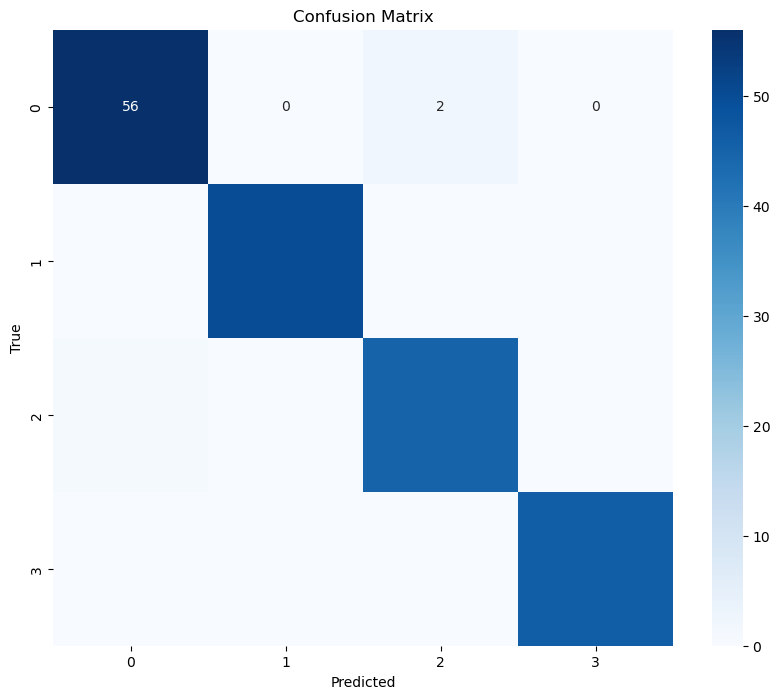

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(c_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
